# Example cases for Pseudobulk DESeq2 analysis

In this notebook, we demonstrate how to retrieve and utilize the DIHA pseudobulk gene expression data to perform pairwise differential expression tests with DESeq2.

There are several helper functions below to assist with sample and gene selection, structuring data for DESeq2, and formatting results generated by DESeq2.

These functions can be chained together (see Example 3) similar to dplyr functions to go from pseudobulk data to nicely formatted differential test results.

We also demonstrate use of the mean expression data for visualization in plots.

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }

quiet_library(hise)
quiet_library(DESeq2)
quiet_library(dplyr)
quiet_library(purrr)
quiet_library(ggplot2)

## Filtering functions

In [2]:
select_pseudobulk_samples <- function(pb_data, ...) {
    pb_data$sample_meta <- pb_data$sample_meta %>%
      filter( ... )

    pb_data$agg_mat <- pb_data$agg_mat[, pb_data$sample_meta$barcodes]
    pb_data$mean_mat <- pb_data$mean_mat[, pb_data$sample_meta$barcodes]
    pb_data$detect_mat <- pb_data$detect_mat[, pb_data$sample_meta$barcodes]

    pb_data
}

**Note**: Select samples first, then select genes to ensure cutoffs are applied to only the samples being used for your test.

In [3]:
select_pseudobulk_genes <- function(pb_data, detect_cutoff = 0.1) {
    detect_totals <- rowSums(pb_data$detect_mat)
    detect_fracs <- detect_totals / sum(pb_data$sample_meta$n_cells)
    keep_genes <- rownames(pb_data$detect_mat)[detect_fracs > detect_cutoff]
    
    pb_data$agg_mat <- pb_data$agg_mat[keep_genes,]
    pb_data$mean_mat <- pb_data$mean_mat[keep_genes,]
    pb_data$detect_mat <- pb_data$detect_mat[keep_genes,]

    pb_data
}

## Conversion to DESeqDataSet format

In [4]:
pseudobulk_to_deseq2 <- function(pb_data, design) {
    
    sample_meta <- as.data.frame(pb_data$sample_meta)
    rownames(sample_meta) <- sample_meta$barcodes
    
    DESeqDataSetFromMatrix(
        pb_data$agg_mat, 
        colData = sample_meta,
        design = {{ design }}
    )
}

## Extract results with nice structure

In [5]:
format_deseq_results <- function(dds, cell_type, group_by, fg, bg) {
    meta <- as.data.frame(colData(dds))
    n_fg <- sum(meta[[group_by]] == fg)
    n_bg <- sum(meta[[group_by]] == bg)
    
    res <- results(dds, contrast = c(group_by, fg, bg))
    res <- data.frame(res)
    
    res <- res %>%
      arrange(padj) %>%
      mutate(direction = ifelse(log2FoldChange > 0,
                                paste0("HigherIn", fg), 
                                paste0("HigherIn", bg))) %>%
      mutate(gene = rownames(.),
             cell_type = cell_type,
             fg = fg, n_fg = n_fg,
             bg = bg, n_bg = n_bg) %>%
      select(cell_type, fg, n_fg, bg, n_bg, gene, log2FoldChange, padj, direction,
             baseMean, lfcSE, stat, pvalue)

    res
    
}

## Plot means per sample to preview results

In [6]:
plot_deseq_results <- function(pb_data, results, group_by, genes, ncol = 3) {
    mean_mat <- t(pb_data$mean_mat[genes,])
    fg <- results$fg[1]
    bg <- results$bg[1]

    xpos_df <- data.frame(
        group = c(fg, bg),
        xpos  = c(1, 2)
    )
    names(xpos_df)[1] <- {{group_by}}
    
    plot_data <- pb_data$sample_meta %>%
      select({{ group_by }}) %>%
      cbind(mean_mat) %>%
      tidyr::pivot_longer(
          one_of(genes),
          names_to = "gene",
          values_to = "mean"
      ) %>%
      mutate(gene = factor(gene, levels = genes)) %>%
      left_join(xpos_df)
    
    sig_data <- results %>%
      filter(gene %in% genes) %>%
      rowwise() %>%
      mutate(gene_max = max(plot_data$mean[plot_data$gene == gene], na.rm = TRUE),
             ypos = gene_max) %>%
      ungroup()
    
    p <- ggplot() +
      geom_boxplot(
          data = plot_data,
          aes(x = xpos + 0.2,
              group = xpos,
              y = mean),
          width = 0.2,
          outlier.size = 0.5
      ) +
      geom_jitter(
          data = plot_data,
          aes(x = xpos - 0.2,
              y = mean),
          width = 0.1,
          size = 0.5
      ) +
      geom_text(
          data = sig_data,
          aes(x = 1.5,
              y = ypos*1.1,
              label = signif(padj,3)),
          vjust = 0
      ) +
      geom_segment(
          data = sig_data,
          aes(x = 1, xend = 2,
              y = ypos * 1.05, yend = ypos * 1.05)
      ) +
      scale_x_continuous(
          group_by,
          breaks = xpos_df$xpos,
          labels = xpos_df[[group_by]]
      ) +
      facet_wrap(
          ~ gene,
          ncol = 3,
          scales = "free_y"
      ) +
      theme_bw()

    p
}

## Retrieve pseudobulk data from HISE

In [7]:
hise_uuid <- "ee32c3fb-916e-4265-818f-1f78483060cc"
hise_res <- cacheFiles(list(hise_uuid))

In [8]:
tar_file <- list.files(paste0("cache/",hise_uuid), full.names = TRUE)
untar_call <- paste("tar -xf", tar_file)
system(untar_call)

## Example case 1

Test CMV status in Adaptive NK cells from BR2 Female samples

Select samples

In [9]:
pb_data <- readRDS("pseudobulk_l3/diha_Adaptive-NK-cell_pseudobulk.rds")

In [10]:
dim(pb_data$agg_mat)

[1] 33538   865

In [11]:
cell_type <- "Adaptive NK cell"

pb_data <- select_pseudobulk_samples(
    pb_data,
    cohort.cohortGuid == "BR2",
    subject.biologicalSex == "Female"
)

In [12]:
dim(pb_data$agg_mat)

[1] 33538   253

Select genes

In [13]:
pb_data <- select_pseudobulk_genes(
    pb_data,
    detect_cutoff = 0.05
)

In [14]:
dim(pb_data$agg_mat)

[1] 6618  253

Convert to DESeq2 object with design

In [15]:
deseq_data <- pseudobulk_to_deseq2(
    pb_data, 
    design = ~ subject.cmv
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


Run DESeq2

In [16]:
deseq_output <- DESeq(deseq_data)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Structure results

In [17]:
deseq_results <- format_deseq_results(
    deseq_output,
    cell_type,
    group_by = "subject.cmv",
    fg = "Positive", bg = "Negative"
)

In [18]:
head(deseq_results)

,cell_type,fg,n_fg,bg,n_bg,gene,log2FoldChange,padj,direction,baseMean,lfcSE,stat,pvalue
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SELL,Adaptive NK cell,Positive,163,Negative,90,SELL,-1.1911208,1.627572e-21,HigherInNegative,23.102969,0.11454300,-10.398897,2.508201e-25
GZMH,Adaptive NK cell,Positive,163,Negative,90,GZMH,0.4654324,2.843111e-20,HigherInPositive,146.065834,0.04629024,10.054654,8.762864e-24
FCER1G,Adaptive NK cell,Positive,163,Negative,90,FCER1G,-0.6172658,7.731360e-19,HigherInNegative,83.946718,0.06374988,-9.682620,3.574369e-22
MTRNR2L8,Adaptive NK cell,Positive,163,Negative,90,MTRNR2L8,-1.7664710,6.453594e-15,HigherInNegative,4.673367,0.20352426,-8.679413,3.978175e-18
CEBPD,Adaptive NK cell,Positive,163,Negative,90,CEBPD,-0.7747188,7.036123e-15,HigherInNegative,15.996495,0.08984031,-8.623287,6.505893e-18
CD3D,Adaptive NK cell,Positive,163,Negative,90,CD3D,1.4021423,7.036123e-15,HigherInPositive,22.010604,0.16228296,8.640108,5.615977e-18


### Plot top results

Joining with `by = join_by(subject.cmv)`


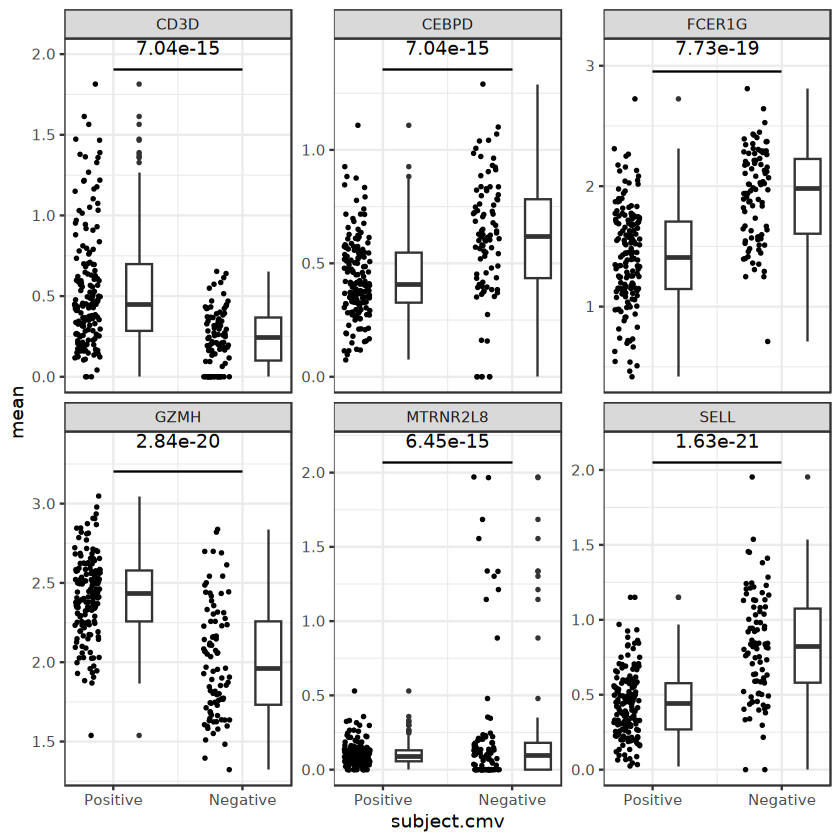

In [19]:
plot_deseq_results(
    pb_data, deseq_results,
    group_by = "subject.cmv",
    genes = head(deseq_results$gene)
)

## Example case 2

Test Flu response in Plasma cells from BR1 CMV+ samples

Select samples

In [20]:
pb_data <- readRDS("pseudobulk_l3/diha_Plasma-cell_pseudobulk.rds")

In [21]:
dim(pb_data$agg_mat)

[1] 33538   850

In [22]:
cell_type <- "Plasma cell"

pb_data <- select_pseudobulk_samples(
    pb_data,
    cohort.cohortGuid == "BR1",
    subject.cmv == "Positive",
    sample.visitName %in% c("Flu Year 1 Day 0", "Flu Year 1 Day 7")
)

In [23]:
dim(pb_data$agg_mat)

[1] 33538    35

Select genes

In [24]:
pb_data <- select_pseudobulk_genes(
    pb_data,
    detect_cutoff = 0.1
)

In [25]:
dim(pb_data$agg_mat)

[1] 7725   35

Convert to DESeq2 object with design

In [26]:
deseq_data <- pseudobulk_to_deseq2(
    pb_data, 
    design = ~ sample.visitName
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



Run DESeq2

In [27]:
deseq_output <- DESeq(deseq_data, quiet = TRUE)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



Structure results

In [28]:
deseq_results <- format_deseq_results(
    deseq_output,
    cell_type,
    group_by = "sample.visitName",
    fg = "Flu Year 1 Day 7", bg = "Flu Year 1 Day 0"
)

In [29]:
head(deseq_results)

,cell_type,fg,n_fg,bg,n_bg,gene,log2FoldChange,padj,direction,baseMean,lfcSE,stat,pvalue
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ASB2,Plasma cell,Flu Year 1 Day 7,18,Flu Year 1 Day 0,17,ASB2,-1.2864758,0.2391302,HigherInFlu Year 1 Day 0,3.060223,0.3176596,-4.049856,5.124907e-05
LTK,Plasma cell,Flu Year 1 Day 7,18,Flu Year 1 Day 0,17,LTK,-1.0960718,0.2391302,HigherInFlu Year 1 Day 0,6.633488,0.2736480,-4.005407,6.191072e-05
EXOSC9,Plasma cell,Flu Year 1 Day 7,18,Flu Year 1 Day 0,17,EXOSC9,-0.7760153,0.7727507,HigherInFlu Year 1 Day 0,5.270538,0.2205191,-3.519038,4.331139e-04
RAD21,Plasma cell,Flu Year 1 Day 7,18,Flu Year 1 Day 0,17,RAD21,-0.5093242,0.7727507,HigherInFlu Year 1 Day 0,19.824227,0.1463294,-3.480669,5.001623e-04
B4GALT1,Plasma cell,Flu Year 1 Day 7,18,Flu Year 1 Day 0,17,B4GALT1,1.4582484,0.7727507,HigherInFlu Year 1 Day 7,24.338660,0.4043013,3.606836,3.099534e-04
MANBA,Plasma cell,Flu Year 1 Day 7,18,Flu Year 1 Day 0,17,MANBA,-1.2467109,0.7916603,HigherInFlu Year 1 Day 0,2.318551,0.3640071,-3.424964,6.148818e-04


Joining with `by = join_by(sample.visitName)`


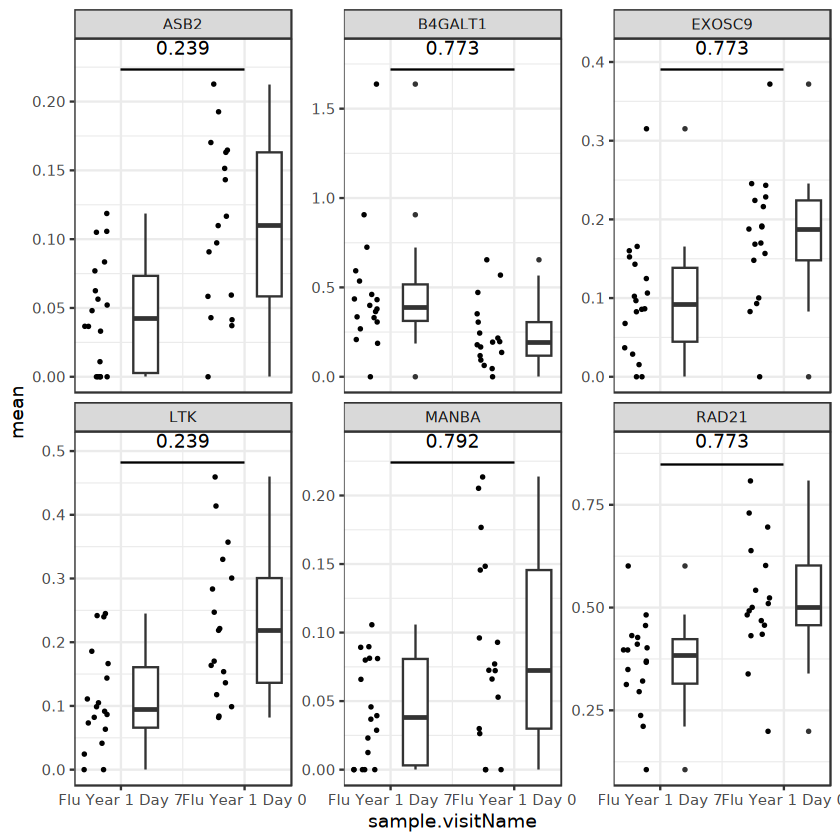

In [30]:
plot_deseq_results(
    pb_data, deseq_results,
    group_by = "sample.visitName",
    genes = head(deseq_results$gene)
)

## Example case 3

Test CMV status in Intermediate monocytes from all Male subjects.
- Chain steps of analysis dplyr-style

In [31]:
pb_data <- readRDS("pseudobulk_l3/diha_Intermediate-monocyte_pseudobulk.rds")

In [32]:
names(pb_data$sample_meta)

[1] "cohort.cohortGuid"       "subject.ageAtFirstDraw" 
 [3] "subject.biologicalSex"   "subject.birthYear"      
 [5] "subject.bmi"             "subject.cmv"            
 [7] "subject.ethnicity"       "subject.race"           
 [9] "subject.subjectGuid"     "sample.drawDate"        
[11] "sample.sampleKitGuid"    "sample.subjectAgeAtDraw"
[13] "sample.visitName"        "specimen.specimenGuid"  
[15] "batch_id"                "pool_id"                
[17] "AIFI_L1"                 "AIFI_L2"                
[19] "AIFI_L3"                 "n_cells"                
[21] "barcodes"

In [33]:
results <- pb_data %>%
  select_pseudobulk_samples(
      subject.biologicalSex == "Male") %>%
  select_pseudobulk_genes(
      detect_cutoff = 0.1) %>%
  pseudobulk_to_deseq2(
      design = ~ subject.cmv) %>%
  DESeq(quiet = TRUE) %>%
  format_deseq_results(
      cell_type = "Intermediate monocyte",
      group_by = "subject.cmv",
      fg = "Positive", bg = "Negative"
  )

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [34]:
head(results)

,cell_type,fg,n_fg,bg,n_bg,gene,log2FoldChange,padj,direction,baseMean,lfcSE,stat,pvalue
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
SLFN5,Intermediate monocyte,Positive,153,Negative,223,SLFN5,0.4491536,1.477972e-13,HigherInPositive,36.96987,0.05297471,8.478643,2.278360e-17
ALDH1A1,Intermediate monocyte,Positive,153,Negative,223,ALDH1A1,0.5486025,1.298453e-09,HigherInPositive,14.53012,0.07561246,7.255451,4.003246e-13
NUDT2,Intermediate monocyte,Positive,153,Negative,223,NUDT2,0.4465904,7.966556e-09,HigherInPositive,16.92003,0.06426876,6.948793,3.684240e-12
RAD51C,Intermediate monocyte,Positive,153,Negative,223,RAD51C,-0.3327847,2.115227e-08,HigherInNegative,10.84103,0.04916914,-6.768162,1.304287e-11
REPIN1,Intermediate monocyte,Positive,153,Negative,223,REPIN1,0.2554517,6.625045e-07,HigherInPositive,15.81323,0.04109716,6.215799,5.106401e-10
NUDT14,Intermediate monocyte,Positive,153,Negative,223,NUDT14,0.3575317,1.133478e-06,HigherInPositive,18.10062,0.05859385,6.101864,1.048384e-09


In [35]:
pb_data <- pb_data %>%
  select_pseudobulk_samples(
      subject.biologicalSex == "Male") %>%
  select_pseudobulk_genes(
      detect_cutoff = 0.1)

Joining with `by = join_by(subject.cmv)`


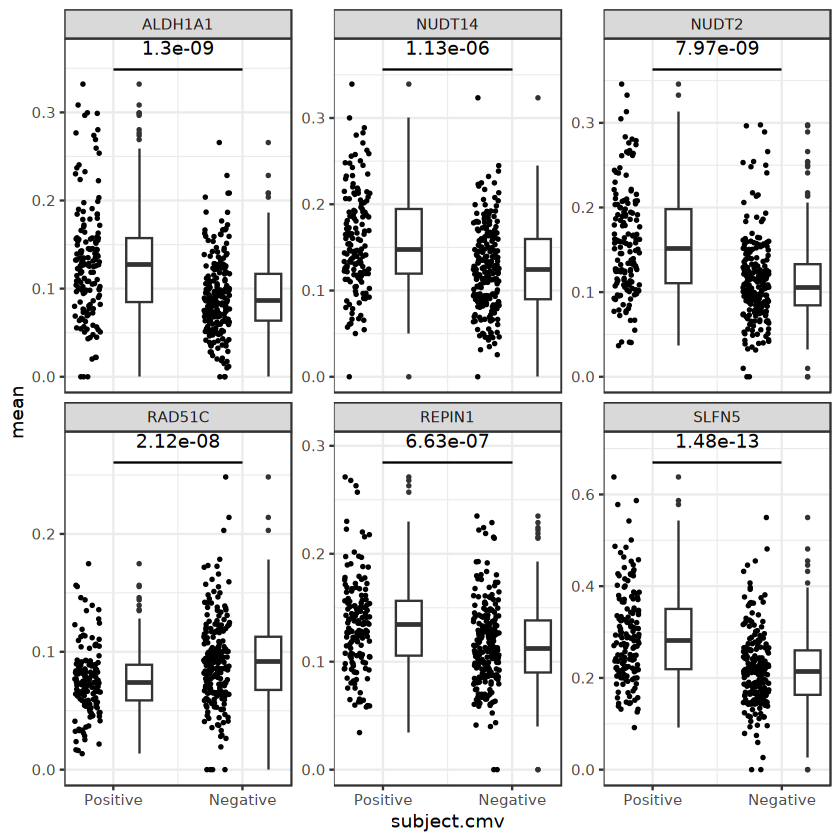

In [38]:
plot_deseq_results(
    pb_data, results,
    group_by = "subject.cmv",
    genes = head(results$gene)
)

In [39]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.25.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggplot2_3.5.0               purrr_1.0.2                
 [3] dplyr_1.1.4                 DESeq2_1.42.0              
 [5] SummarizedExperiment_1.32.0 Biobase_2.62.0             
 [7] MatrixGenerics_1.14.0       matrixStats_1.2.0          
 [9] GenomicRanges_1.54.1        GenomeInfoDb_1.38.5   